# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Данные находятся в файле /datasets/Churn.csv

# 1. Подготовка данных

In [261]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [262]:
data = pd.read_csv('/datasets/Churn.csv')
display(data.head())
data.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [263]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [264]:
data.columns = ['rowNumber', 'customerId', 'surname', 'creditScore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numOfProducts', 'hasCrCard',
       'isActiveMember', 'estimatedSalary', 'exited']

Были получены данные о клиентах банка, в ходе их изучения были обнаружены пропуски в поле tenure. Полсе, названия всех полей были приведены к нижнему регистру.

In [265]:
#функция для нахождения полей с пропущенными значениями
def field_nun(data):  
    columns = data.columns
    print('{:<20} {:<}'.format('Поле', 'Количество пропусков'))
    print()
    for i in columns:
        empty_count = data.loc[data[i].isnull()]['rowNumber'].count()
        if empty_count != 0:
            print('{:<20} {:<5}'.format(i, empty_count))


field_nun(data)

Поле                 Количество пропусков

tenure               909  


In [266]:
data.loc[data['tenure'].isnull(), 'tenure'] = data['tenure'].median()
data = data.drop_duplicates().reset_index(drop = True)

Обнаружено 909 пропусков в поле tenure, они были заменены на мединное значение по полю. Также были удалены дубликаты записей.

# 2. Исследование задачи

In [267]:
#получение баланса классов целевого признака
display(data['exited'].value_counts())

0    7963
1    2037
Name: exited, dtype: int64

In [268]:
#создание выборки без полей, которые будут влиять на обучение модели в худшую сторону
ml_data = data.drop(['rowNumber', 'customerId', 'surname'], axis = 1)

In [269]:
#преобразование строковых полей в численные
encoder = OrdinalEncoder()
ml_data = pd.DataFrame(encoder.fit_transform(ml_data), columns = ml_data.columns)

In [270]:
#разбиение на тренировочную, валидационную и тестовую выборки
#определение целевого и остальных признаков
data_train, data_40 = train_test_split(ml_data, test_size = 0.4, random_state = 12345)
data_valid, data_test = train_test_split(data_40, test_size = 0.5, random_state = 12345)


def features_turget_fun(data):
    features = data.drop('exited', axis = 1)
    target = data['exited']
    return features, target


features_train, target_train = features_turget_fun(data_train)
features_valid, target_valid = features_turget_fun(data_valid)
features_test, target_test = features_turget_fun(data_test)

In [271]:
#обучение модели Дерева решенй на глубине 10
model_1 = DecisionTreeClassifier(random_state = 12345, max_depth = 10)
model_1.fit(features_train, target_train)
prediction_1 = model_1.predict(features_valid)
display('Характеристика F1 для модели решающего дерева', f1_score(target_valid, prediction_1))

'Характеристика F1 для модели решающего дерева'

0.4992826398852224

'Характеристика F1 для модели случайного леса'

0.5655608214849921

[[1546   36]
 [ 239  179]]


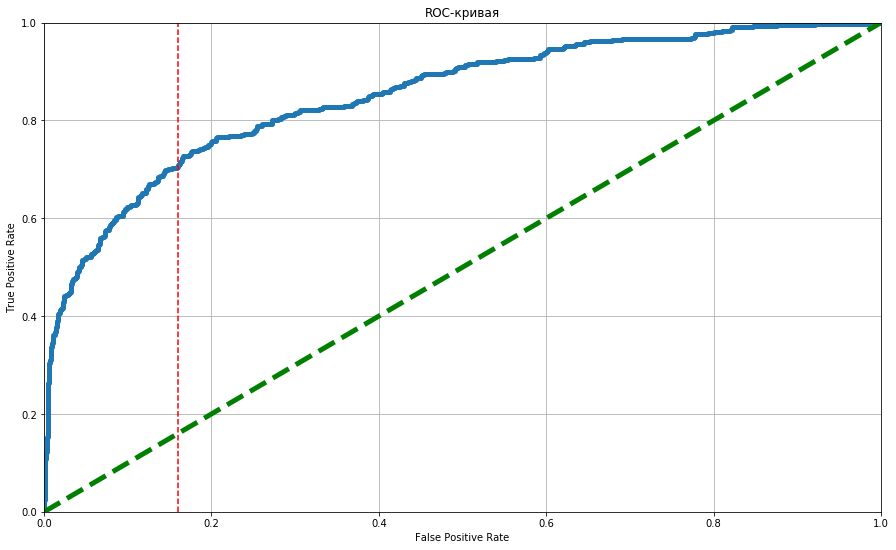

значение auc_roc = 0.8515324917281136


In [272]:
#обучение модели Случайного леса на глубине 10 с количеством деревьев 50
model_2 = RandomForestClassifier(random_state = 12345, max_depth = 10, n_estimators = 50)
model_2.fit(features_train, target_train)
prediction_2 = model_2.predict(features_valid)
display('Характеристика F1 для модели случайного леса', f1_score(target_valid, prediction_2))
print(confusion_matrix(target_valid, prediction_2))
probabilities_valid = model_2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure(figsize=(15, 9))
plt.grid()
plt.plot(fpr, tpr,linewidth = 5)
plt.axvline(x=0.16, ymin=0, ymax=1, color = 'r', linestyle = '--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], linestyle='--',linewidth = 5,color = 'g')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('значение auc_roc =', auc_roc)

Была получена ROC-кривая модели случайного леса. По красной линии можно определить значение порога, при котором максимально значение TPR и минимально значение FPR. Красная пунктирная линия проведена на значении  0.16 по х, и в пересечении красной линии и синей кривой будет точка с максимально благоприятным порогом для модели.

In [273]:
#обучение модели Логистической регрессии
model_3 = LogisticRegression(random_state = 12345, solver = 'liblinear')
model_3.fit(features_train, target_train)
prediction_3 = model_3.predict(features_valid)
display('Характеристика F1 для модели логистической регрессии', f1_score(target_valid, prediction_3))

'Характеристика F1 для модели логистической регрессии'

0.2742230347349177

После изучений значений F1 мер различныз моделей была выбрана модель случайного леса с f1 = 0.565. Вернемся к этой модели и изучим ROC-кривую.

# 3. Борьба с дисбалансом

In [274]:
#пересодадим тренировочную, валидационную и тестовую выборки с параметром stratify
data_train, data_40 = train_test_split(ml_data, test_size = 0.4, random_state = 12345, stratify = data['exited'])
data_valid, data_test = train_test_split(data_40, test_size = 0.5, random_state = 12345, stratify = data_40['exited'])

features_train, target_train = features_turget_fun(data_train)
features_valid, target_valid = features_turget_fun(data_valid)
features_test, target_test = features_turget_fun(data_test)


features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

features_upsampled = pd.concat([features_zeros] + [features_ones] * 4)
target_upsampled = pd.concat([target_zeros] + [target_ones] * 4) 
features_train, target_train = shuffle(
features_upsampled, target_upsampled, random_state=12345)

In [249]:
dtc_model = None
best_f1 = 0
best_depth = 0
for depth in range(1, 11, 1):
    model = DecisionTreeClassifier(max_depth = depth, random_state = 12345)
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)
    result = f1_score(target_valid, prediction_valid)
    if result > best_f1:
        dtc_model = model
        best_f1 = result
        best_depth = depth
        probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
        

print('Значение f1  для модели дерева решений', best_f1)
print(best_depth)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('значение auc_roc =', auc_roc)

Значение f1  для модели дерева решений 0.5787545787545788
7
значение auc_roc = 0.8201262131737117


In [252]:
best_f1 = 0
best_depth = 0
best_est = 0
for est in range(65, 75, 1):
    for depth in range (1, 11, 1):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth,class_weight = 'balanced')
        model.fit(features_train, target_train)
        prediction_valid = model.predict(features_valid)
        result = f1_score(target_valid, prediction_valid)
        if result > best_f1:
            best_rfc = model
            best_f1 = result
            best_depth = depth
            best_est = est
            probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
            
print('Значение f1  для модели случайного леса', best_f1)
print(best_depth, best_est)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('значение auc_roc =', auc_roc)

Значение f1  для модели случайного леса 0.6476399560922064
10 69
значение auc_roc = 0.8666124741353829


In [253]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear', class_weight = 'balanced')
model_lr.fit(features_train, target_train)
prediction_valid = model_lr.predict(features_valid)
probabilities_one_valid = model_lr.predict_proba(features_valid)[:, 1]
print('Значение f1  для модели логистической регрессии', f1_score(target_valid, prediction_valid))
print('значение auc_roc =', roc_auc_score(target_valid, probabilities_one_valid))

Значение f1  для модели логистической регрессии 0.49870129870129876
значение auc_roc = 0.7752657281505568


После обучения поделей Логистической регрессиии, Случайного леса, и Дерева решений с параметрами стратификации по полю exited, и весом слассов при обучении - balanced, при подборе наиболее благоприятных гипперпараметров, исзодя из значения f1 и auc_roc_score была выбрана модель Случайного леса с глубиной дерева 9 и количеством деревьев 35.

In [257]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train), columns = features_train.columns)
features_valid = pd.DataFrame(scaler.transform(features_valid), columns = features_train.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns = features_train.columns)

In [275]:
model = RandomForestClassifier(random_state=12345, n_estimators=69, max_depth=10)
model.fit(features_train, target_train)
prediction_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(f1_score(target_valid, prediction_valid))
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('значение auc_roc =', auc_roc)
print(confusion_matrix(target_valid, prediction_valid))

for threshold in np.arange(0.4, 0.6, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | f1 = {:.3f}".format(
        threshold, f1))


0.6446644664466448
значение auc_roc = 0.8660382180510395
[[1384  208]
 [ 115  293]]
Порог = 0.40 | f1 = 0.606
Порог = 0.42 | f1 = 0.620
Порог = 0.44 | f1 = 0.629
Порог = 0.46 | f1 = 0.637
Порог = 0.48 | f1 = 0.641
Порог = 0.50 | f1 = 0.645
Порог = 0.52 | f1 = 0.642
Порог = 0.54 | f1 = 0.632
Порог = 0.56 | f1 = 0.622
Порог = 0.58 | f1 = 0.612


После выбора лучшей модели, значения признаков были промасштбированы. Модель идентичная лучшей была обучена на новых данных.
Значения f1 и auc-roc получились такими же. При определении наилучшего порога изучялись сами пороги и значения f1 на них.
Как следствие, лучший порог равен 0.5

# 4. Тестирование модели

0.5929203539823009


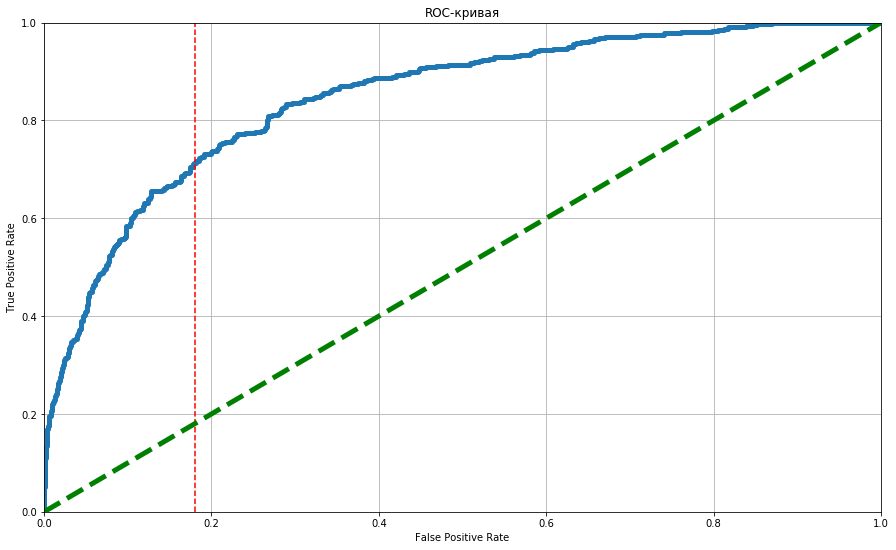

значение f1_score = 0.5929203539823009
значение auc_roc = 0.8473727965253389


In [279]:
prediction_test = model.predict(features_test)
print(f1_score(target_test, prediction_test))
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure(figsize=(15, 9))
plt.grid()
plt.plot(fpr, tpr,linewidth = 5)
plt.axvline(x=0.18, ymin=0, ymax=1, color = 'r', linestyle = '--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], linestyle='--',linewidth = 5,color = 'g')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

print('значение f1_score =', f1_score(target_test, prediction_test))
print('значение auc_roc =', roc_auc_score(target_test, probabilities_one_test))

После тестирования модели значения f1 и auc_roc получились следующими: значение f1_score = 0.593, 
значение auc_roc = 0.85. В данном проекте требовалось довести значение f1 выше 0.59.
Поставленная задача выполнена.

# Общий вывод

В ходе данного проекта было проделано следующее: 
1. Были получены данные о клиентах банка, в ходе их изучения были обнаружены пропуски в поле tenure. Полсе, названия всех полей были приведены к нижнему регистру.
2. Обнаружено 909 пропусков в поле tenure, они были заменены на мединное значение по полю. Также были удалены дубликаты записей.
3. После изучений значений F1 мер различныз моделей была выбрана модель случайного леса с f1 = 0.565
4. Была получена ROC-кривая модели случайного леса. По красной линии можно определить значение порога, при котором максимально значение TPR и минимально значение FPR. Красная пунктирная линия проведена на значении 0.16 по х, и в пересечении красной линии и синей кривой будет точка с максимально благоприятным порогом для модели.
5. После обучения поделей Логистической регрессиии, Случайного леса, и Дерева решений с параметрами стратификации по полю exited, и весом слассов при обучении - balanced, при подборе наиболее благоприятных гипперпараметров, исзодя из значения f1 и auc_roc_score была выбрана модель Случайного леса с глубиной дерева 9 и количеством деревьев 35.
6. После выбора лучшей модели, значения признаков были промасштбированы. Модель идентичная лучшей была обучена на новых данных. Значения f1 и auc-roc получились такими же. При определении наилучшего порога изучялись сами пороги и значения f1 на них. Как следствие, лучший порог равен 0.5
7. После тестирования модели значения f1 и auc_roc получились следующими: значение f1_score = 0.593, значение auc_roc = 0.85. 
8. В данном проекте требовалось довести значение f1 выше 0.59. Поставленная задача выполнена.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*